In [1]:
import pandas as pd
import os
import torch
import numpy as np
from PIL import Image
import cv2
import random
import timm
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

In [2]:
# read file
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

# Add file path to dataframe
train['image_path'] = os.getcwd() + '/train_images_5/' + 'spec_' + train['ID']+'.png'
test['image_path'] = os.getcwd() + '/test_images_5/' + 'spec_' + test['ID']+'.png'

##### Utilities

In [3]:
class CFG:
    seed=42
    device='cuda' if torch.cuda.is_available() else 'cpu'
    folds=10
    skf_folds=10
    apex=True
    epochs=15
    batch_size=8
    lr=1e-4
    weight_decay=1e-2
    model_name = 'maxvit_large_tf_224'
    clip_val = 1000.



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=False)


%env CUBLAS_WORKSPACE_CONFIG=:4096:8


seed_everything(CFG.seed)

# function for evaluating the model
def evaluate_model(cfg, model, data_loader, epoch=-1):
    loss_fn =torch.nn.BCEWithLogitsLoss(
                                    # weight=cfg.weights.to(cfg.device), 
                                    # label_smoothing=0.1
                                    )

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["label"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        loss = loss_fn(logits, target)
        val_loss += loss.item()

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target, logits

    val_loss /= total_len

    print(f'Epoch {epoch} validation loss = {val_loss:.4f}')
    return val_loss

# function for training the model
def train_epoch(cfg, model, train_loader, optimizer, scheduler, epoch):
    scaler = torch.amp.GradScaler(device=cfg.device, enabled=cfg.apex)
    loss_fn = torch.nn.BCEWithLogitsLoss(
                                # weight=cfg.weights.to(cfg.device),   
                                #   label_smoothing=0.1
                                  )

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["label"].to(cfg.device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.amp.autocast(device_type=cfg.device, enabled=cfg.apex):
            logits = model(input)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target


    train_loss /= total_len

    print(f'Epoch {epoch} train loss = {train_loss:.4f}')
    return train_loss, learning_rate_history


def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota




def training_fn(cfg, dataloader, model, opt, criterion, epoch):
    avg_loss = 0
    avg_acc = 0
    avg_logloss = 0

    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(cfg.device), data['label'].to(cfg.device)

        opt.zero_grad()

        pred = model(x)
        # break # testing things

        pred = F.sigmoid(pred)
      
        loss = criterion(pred, y)


        avg_loss += loss
        avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
        avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())

        loss.backward()
        opt.step()

    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()
    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader),
                                                                            avg_logloss/len(dataloader)))
    
    return avg_loss_nump
    # return y, pred
    
def evaluate(cfg, dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
      x = data['image'].to(cfg.device)
      y = data['label'].to(cfg.device)

      pred = model(x)

      pred = F.sigmoid(pred)

      avg_loss += criterion(pred, y)
      avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
      avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    avg_logloss /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy(), avg_logloss))
    
  return avg_logloss 

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


##### Preprocessing

In [4]:
# string class mapping to integer
class_map = {name:idx for idx, name in enumerate(train['common_name'].unique())}

# apply class map to train dataset
train['label'] = train['common_name'].map(class_map)

# filter dataframe to contain only good audios
all_images = [image_name.split('_')[1].split('.')[0] for image_name in os.listdir(os.getcwd() + '/train_images')]
bad_audio = [filename for filename in train['ID'] if filename not in all_images]
train = train[~train['ID'].isin(bad_audio)].reset_index(drop=True)


##### Image-Transformation

In [5]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=False)
])

val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=False)
])

##### Custom-Dataset

In [6]:
class AudioDataset(Dataset):
    def __init__(self,
                dataframe,
                transforms,
                size=(224, 224),
                train=True
                ):
        self.dataframe = dataframe
        self.transforms = transforms
        self.size = size
        self.train = train

    def __len__(self):
        return len(self.dataframe)

        
    def __getitem__(self, index):
        # get row data
        row = self.dataframe.iloc[index]

        
        # load image
        image = cv2.imread(row.image_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(src=image, dsize=self.size)

        # convert to tensor
        tensor_image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        # apply transform
        # image = self.transforms(image)

        if self.train:
            # get label
            label = row.label
            label_tensor = F.one_hot(torch.tensor(label, dtype=torch.long), num_classes=40).float()
            return {'image':tensor_image, 'label':label_tensor}
        else:
            return {'image':tensor_image}
            

##### Model

In [7]:
# define custom audio model
class AudioModel(torch.nn.Module):
    def __init__(self, backbone='resnet34', 
                 pretrained=True, fc_size=512,
                  out_size=40):
        super(AudioModel, self).__init__()

        self.arch = getattr(models, backbone)(pretrained)

        head = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), 
                               stride=(2, 2),
                               padding=(3, 3)
                               )
        head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

        self.arch.conv1 = head
        self.arch.fc = torch.nn.Linear(fc_size, out_size)
        torch.nn.init.xavier_normal_(self.arch.fc.weight)

    def forward(self, x):
        x = self.arch(x)
        x= F.sigmoid(x)

        return x


In [8]:
# use timm to select model
timm.list_models('*maxvit*')

['maxvit_base_tf_224',
 'maxvit_base_tf_384',
 'maxvit_base_tf_512',
 'maxvit_large_tf_224',
 'maxvit_large_tf_384',
 'maxvit_large_tf_512',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_base_rw_224',
 'maxvit_rmlp_base_rw_384',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_tf_224',
 'maxvit_small_tf_384',
 'maxvit_small_tf_512',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_tiny_tf_224',
 'maxvit_tiny_tf_384',
 'maxvit_tiny_tf_512',
 'maxvit_xlarge_tf_224',
 'maxvit_xlarge_tf_384',
 'maxvit_xlarge_tf_512']

##### Modelling

In [9]:
# cross validation
train['folds'] = np.nan
skf = StratifiedKFold(n_splits=CFG.skf_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(train['ID'].values, train['label'].values)):
    train.loc[test_index, 'folds'] = i


class STYLE:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,4,3,3,4,3,4,3,9,...,3,10,7,3,3,5,3,4,6,3
train,41,31,27,31,30,30,29,33,34,78,...,28,90,59,29,29,41,33,30,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16371 - Acc : 0.03606 - LogLoss 3.66785
[Evaluation] Loss: 0.11544 - Acc : 0.05208 - LogLoss 3.63051
New best score: 1000000.0000 -> 3.6305
[Training] Epoch 1 : Loss: 0.10916 - Acc : 0.16466 - LogLoss 3.37751
[Evaluation] Loss: 0.09619 - Acc : 0.34896 - LogLoss 2.82757
New best score: 3.6305 -> 2.8276
[Training] Epoch 2 : Loss: 0.08090 - Acc : 0.47957 - LogLoss 2.34598
[Evaluation] Loss: 0.07058 - Acc : 0.53646 - LogLoss 1.99791
New best score: 2.8276 -> 1.9979
[Training] Epoch 3 : Loss: 0.05227 - Acc : 0.72776 - LogLoss 1.41646
[Evaluation] Loss: 0.05389 - Acc : 0.64062 - LogLoss 1.47722
New best score: 1.9979 -> 1.4772
[Training] Epoch 4 : Loss: 0.03269 - Acc : 0.85817 - LogLoss 0.83632
[Evaluation] Loss: 0.05033 - Acc : 0.64062 - LogLoss 1.37923
New best score: 1.4772 -> 1.3792
[Training] Epoch 5 : Loss: 0.02033 - Acc : 0.93149 - LogLoss 0.49412
[Evaluation] Loss: 0.04501 - Acc : 0.66667 - LogLoss 1.18730
New best score: 1.3

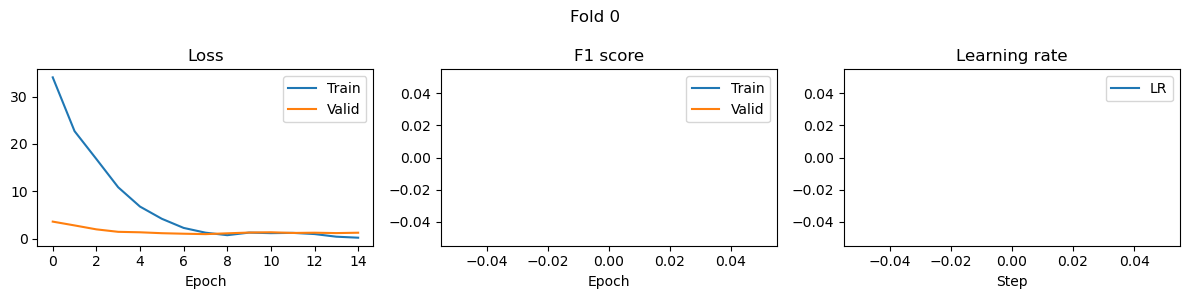

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,3,4,3,4,3,3,4,9,...,3,10,7,3,3,5,3,4,6,3
train,41,31,28,30,30,30,29,34,33,78,...,28,90,59,29,29,41,33,30,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16382 - Acc : 0.04087 - LogLoss 3.66714
[Evaluation] Loss: 0.11529 - Acc : 0.05208 - LogLoss 3.62451
New best score: 1000000.0000 -> 3.6245
[Training] Epoch 1 : Loss: 0.10744 - Acc : 0.18450 - LogLoss 3.30994
[Evaluation] Loss: 0.09392 - Acc : 0.41146 - LogLoss 2.78369
New best score: 3.6245 -> 2.7837
[Training] Epoch 2 : Loss: 0.07913 - Acc : 0.49700 - LogLoss 2.28621
[Evaluation] Loss: 0.06719 - Acc : 0.65104 - LogLoss 1.87086
New best score: 2.7837 -> 1.8709
[Training] Epoch 3 : Loss: 0.05142 - Acc : 0.73317 - LogLoss 1.38524
[Evaluation] Loss: 0.05288 - Acc : 0.68750 - LogLoss 1.45046
New best score: 1.8709 -> 1.4505
[Training] Epoch 4 : Loss: 0.03194 - Acc : 0.86839 - LogLoss 0.81218
[Evaluation] Loss: 0.04243 - Acc : 0.76042 - LogLoss 1.12652
New best score: 1.4505 -> 1.1265
[Training] Epoch 5 : Loss: 0.01778 - Acc : 0.95132 - LogLoss 0.42885
[Evaluation] Loss: 0.03539 - Acc : 0.78125 - LogLoss 0.92748
New best score: 1.1

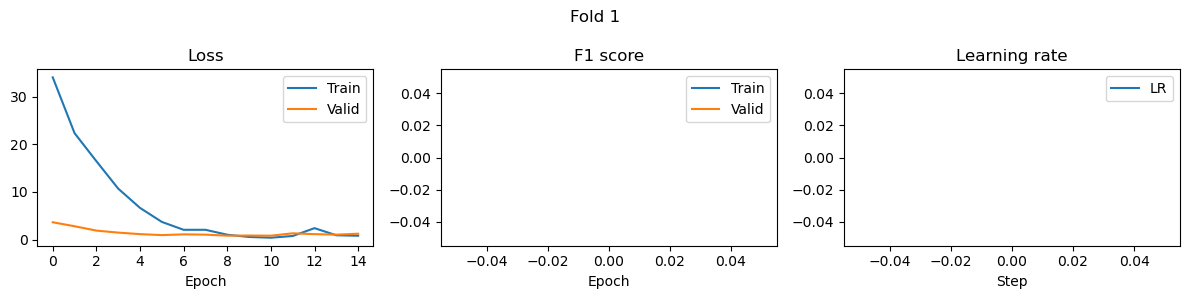

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,3,4,3,3,4,3,4,9,...,3,10,7,3,3,5,3,4,6,3
train,41,31,28,30,30,31,28,34,33,78,...,28,90,59,29,29,41,33,30,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16384 - Acc : 0.03726 - LogLoss 3.66448
[Evaluation] Loss: 0.11531 - Acc : 0.05208 - LogLoss 3.62545
New best score: 1000000.0000 -> 3.6255
[Training] Epoch 1 : Loss: 0.10676 - Acc : 0.19471 - LogLoss 3.28486
[Evaluation] Loss: 0.09438 - Acc : 0.36979 - LogLoss 2.80303
New best score: 3.6255 -> 2.8030
[Training] Epoch 2 : Loss: 0.07697 - Acc : 0.51923 - LogLoss 2.21332
[Evaluation] Loss: 0.06910 - Acc : 0.62500 - LogLoss 1.92666
New best score: 2.8030 -> 1.9267
[Training] Epoch 3 : Loss: 0.04988 - Acc : 0.73858 - LogLoss 1.33839
[Evaluation] Loss: 0.05700 - Acc : 0.61458 - LogLoss 1.56879
New best score: 1.9267 -> 1.5688
[Training] Epoch 4 : Loss: 0.03105 - Acc : 0.87740 - LogLoss 0.78972
[Evaluation] Loss: 0.04759 - Acc : 0.68750 - LogLoss 1.29571
New best score: 1.5688 -> 1.2957
[Training] Epoch 5 : Loss: 0.01712 - Acc : 0.95132 - LogLoss 0.41110
[Evaluation] Loss: 0.04409 - Acc : 0.70312 - LogLoss 1.19938
New best score: 1.2

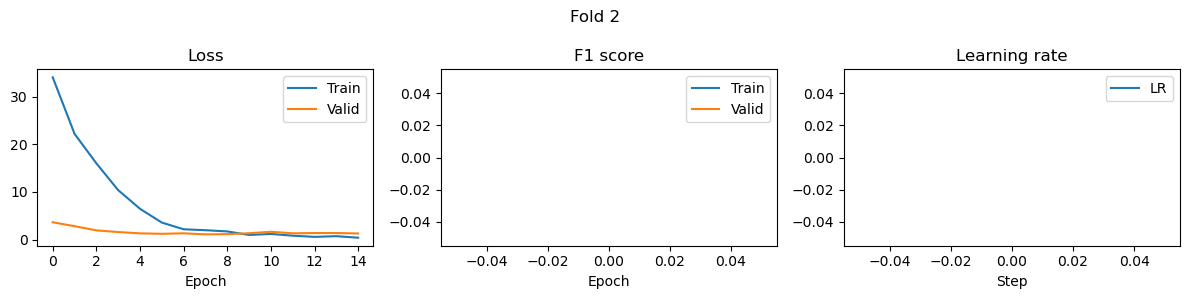

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,3,4,3,3,4,3,4,9,...,3,10,6,4,3,4,4,3,7,3
train,41,31,28,30,30,31,28,34,33,78,...,28,90,60,28,29,42,32,31,54,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16310 - Acc : 0.03846 - LogLoss 3.66357
[Evaluation] Loss: 0.11546 - Acc : 0.05208 - LogLoss 3.62970
New best score: 1000000.0000 -> 3.6297
[Training] Epoch 1 : Loss: 0.10550 - Acc : 0.20553 - LogLoss 3.23611
[Evaluation] Loss: 0.09159 - Acc : 0.39062 - LogLoss 2.69554
New best score: 3.6297 -> 2.6955
[Training] Epoch 2 : Loss: 0.07591 - Acc : 0.53125 - LogLoss 2.17691
[Evaluation] Loss: 0.06720 - Acc : 0.65625 - LogLoss 1.89018
New best score: 2.6955 -> 1.8902
[Training] Epoch 3 : Loss: 0.04882 - Acc : 0.74700 - LogLoss 1.30755
[Evaluation] Loss: 0.05198 - Acc : 0.69271 - LogLoss 1.41246
New best score: 1.8902 -> 1.4125
[Training] Epoch 4 : Loss: 0.02863 - Acc : 0.90445 - LogLoss 0.71877
[Evaluation] Loss: 0.04239 - Acc : 0.71354 - LogLoss 1.13190
New best score: 1.4125 -> 1.1319
[Training] Epoch 5 : Loss: 0.01576 - Acc : 0.96274 - LogLoss 0.37527
[Evaluation] Loss: 0.03894 - Acc : 0.74479 - LogLoss 1.06633
New best score: 1.1

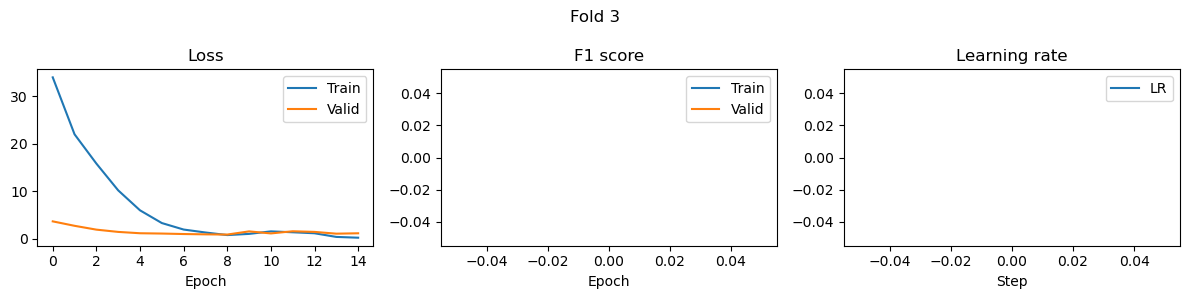

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,3,4,3,3,3,4,4,9,...,3,10,6,4,3,4,4,3,6,4
train,41,31,28,30,30,31,29,33,33,78,...,28,90,60,28,29,42,32,31,55,27


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16384 - Acc : 0.04087 - LogLoss 3.66457
[Evaluation] Loss: 0.11531 - Acc : 0.05208 - LogLoss 3.62487
New best score: 1000000.0000 -> 3.6249
[Training] Epoch 1 : Loss: 0.10667 - Acc : 0.19411 - LogLoss 3.28071
[Evaluation] Loss: 0.09694 - Acc : 0.32812 - LogLoss 2.89869
New best score: 3.6249 -> 2.8987
[Training] Epoch 2 : Loss: 0.07732 - Acc : 0.51082 - LogLoss 2.22402
[Evaluation] Loss: 0.07296 - Acc : 0.56771 - LogLoss 2.08390
New best score: 2.8987 -> 2.0839
[Training] Epoch 3 : Loss: 0.04887 - Acc : 0.75841 - LogLoss 1.30972
[Evaluation] Loss: 0.06062 - Acc : 0.61979 - LogLoss 1.67767
New best score: 2.0839 -> 1.6777
[Training] Epoch 4 : Loss: 0.02851 - Acc : 0.89543 - LogLoss 0.71454
[Evaluation] Loss: 0.05162 - Acc : 0.63542 - LogLoss 1.41425
New best score: 1.6777 -> 1.4143
[Training] Epoch 5 : Loss: 0.01670 - Acc : 0.94832 - LogLoss 0.40140
[Evaluation] Loss: 0.04599 - Acc : 0.71354 - LogLoss 1.26158
New best score: 1.4

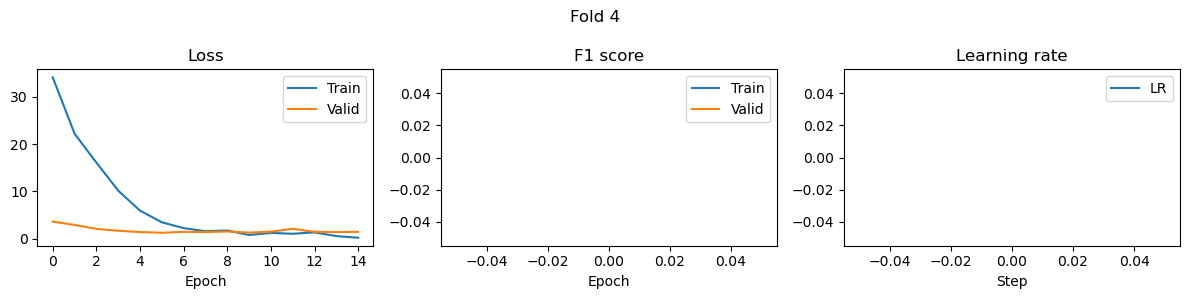

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,5,3,3,3,4,3,3,4,4,8,...,3,10,6,3,4,4,4,3,6,3
train,41,31,28,31,29,31,29,33,33,79,...,28,90,60,29,28,42,32,31,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16350 - Acc : 0.03906 - LogLoss 3.67110
[Evaluation] Loss: 0.11547 - Acc : 0.04688 - LogLoss 3.63242
New best score: 1000000.0000 -> 3.6324
[Training] Epoch 1 : Loss: 0.10724 - Acc : 0.17248 - LogLoss 3.30302
[Evaluation] Loss: 0.09610 - Acc : 0.35417 - LogLoss 2.77736
New best score: 3.6324 -> 2.7774
[Training] Epoch 2 : Loss: 0.07793 - Acc : 0.51022 - LogLoss 2.24377
[Evaluation] Loss: 0.07454 - Acc : 0.48438 - LogLoss 2.12340
New best score: 2.7774 -> 2.1234
[Training] Epoch 3 : Loss: 0.04915 - Acc : 0.76022 - LogLoss 1.31841
[Evaluation] Loss: 0.05372 - Acc : 0.62500 - LogLoss 1.46024
New best score: 2.1234 -> 1.4602
[Training] Epoch 4 : Loss: 0.02891 - Acc : 0.89303 - LogLoss 0.72670
[Evaluation] Loss: 0.04304 - Acc : 0.72396 - LogLoss 1.13882
New best score: 1.4602 -> 1.1388
[Training] Epoch 5 : Loss: 0.01677 - Acc : 0.95553 - LogLoss 0.39852
[Evaluation] Loss: 0.04782 - Acc : 0.67188 - LogLoss 1.31087
[Training] Epoch 6 

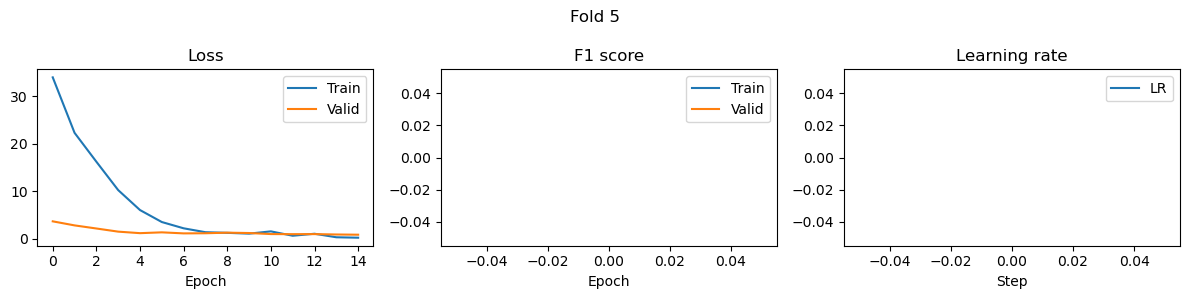

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,4,4,3,3,4,3,3,4,4,8,...,4,10,6,3,4,4,4,3,6,3
train,42,30,28,31,29,31,29,33,33,79,...,27,90,60,29,28,42,32,31,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16431 - Acc : 0.03606 - LogLoss 3.67232
[Evaluation] Loss: 0.11571 - Acc : 0.04688 - LogLoss 3.64234
New best score: 1000000.0000 -> 3.6423
[Training] Epoch 1 : Loss: 0.10888 - Acc : 0.15986 - LogLoss 3.36678
[Evaluation] Loss: 0.09966 - Acc : 0.32812 - LogLoss 2.91419
New best score: 3.6423 -> 2.9142
[Training] Epoch 2 : Loss: 0.08049 - Acc : 0.48918 - LogLoss 2.33079
[Evaluation] Loss: 0.07202 - Acc : 0.57292 - LogLoss 2.03699
New best score: 2.9142 -> 2.0370
[Training] Epoch 3 : Loss: 0.05160 - Acc : 0.73738 - LogLoss 1.39252
[Evaluation] Loss: 0.05406 - Acc : 0.64062 - LogLoss 1.49088
New best score: 2.0370 -> 1.4909
[Training] Epoch 4 : Loss: 0.03153 - Acc : 0.87260 - LogLoss 0.80122
[Evaluation] Loss: 0.04100 - Acc : 0.76042 - LogLoss 1.09075
New best score: 1.4909 -> 1.0907
[Training] Epoch 5 : Loss: 0.01721 - Acc : 0.95433 - LogLoss 0.41270
[Evaluation] Loss: 0.04039 - Acc : 0.72917 - LogLoss 1.10412
[Training] Epoch 6 

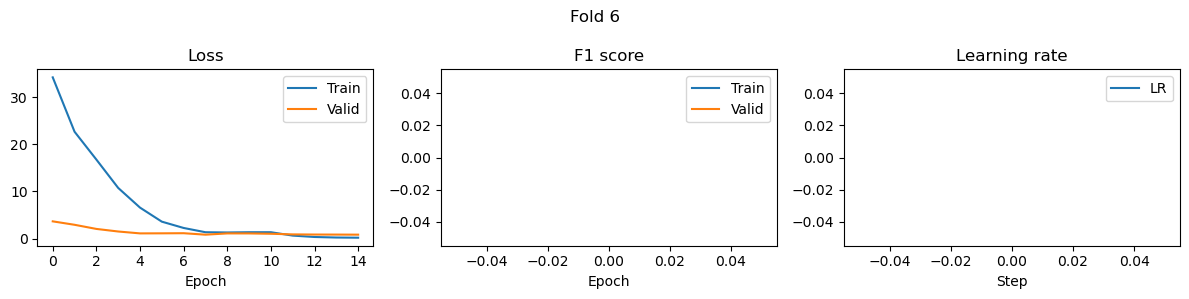

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,4,4,3,3,4,3,3,4,4,8,...,3,10,7,3,3,5,4,3,6,3
train,42,30,28,31,29,31,29,33,33,79,...,28,90,59,29,29,41,32,31,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16359 - Acc : 0.04087 - LogLoss 3.67118
[Evaluation] Loss: 0.11554 - Acc : 0.04167 - LogLoss 3.63492
New best score: 1000000.0000 -> 3.6349
[Training] Epoch 1 : Loss: 0.10650 - Acc : 0.18630 - LogLoss 3.27455
[Evaluation] Loss: 0.09584 - Acc : 0.37500 - LogLoss 2.83593
New best score: 3.6349 -> 2.8359
[Training] Epoch 2 : Loss: 0.07688 - Acc : 0.51382 - LogLoss 2.20956
[Evaluation] Loss: 0.07857 - Acc : 0.50521 - LogLoss 2.23170
New best score: 2.8359 -> 2.2317
[Training] Epoch 3 : Loss: 0.04862 - Acc : 0.76683 - LogLoss 1.29893
[Evaluation] Loss: 0.05894 - Acc : 0.60417 - LogLoss 1.63613
New best score: 2.2317 -> 1.6361
[Training] Epoch 4 : Loss: 0.02761 - Acc : 0.90204 - LogLoss 0.68838
[Evaluation] Loss: 0.05021 - Acc : 0.65104 - LogLoss 1.37737
New best score: 1.6361 -> 1.3774
[Training] Epoch 5 : Loss: 0.01448 - Acc : 0.97055 - LogLoss 0.34235
[Evaluation] Loss: 0.05199 - Acc : 0.62500 - LogLoss 1.44427
[Training] Epoch 6 

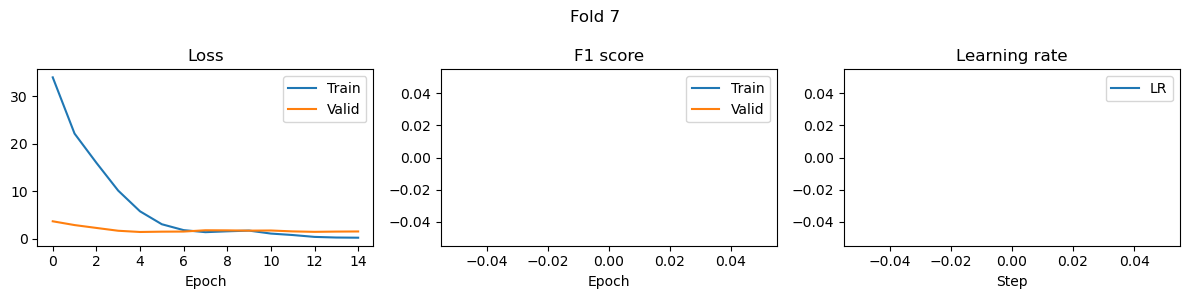

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,4,4,3,3,3,4,3,4,3,9,...,3,10,7,3,3,5,4,3,6,3
train,42,30,28,31,30,30,29,33,34,78,...,28,90,59,29,29,41,32,31,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16380 - Acc : 0.04026 - LogLoss 3.67281
[Evaluation] Loss: 0.11569 - Acc : 0.04167 - LogLoss 3.64150
New best score: 1000000.0000 -> 3.6415
[Training] Epoch 1 : Loss: 0.10774 - Acc : 0.17668 - LogLoss 3.32259
[Evaluation] Loss: 0.10030 - Acc : 0.30729 - LogLoss 2.92879
New best score: 3.6415 -> 2.9288
[Training] Epoch 2 : Loss: 0.07850 - Acc : 0.50240 - LogLoss 2.26363
[Evaluation] Loss: 0.07177 - Acc : 0.52604 - LogLoss 2.01279
New best score: 2.9288 -> 2.0128
[Training] Epoch 3 : Loss: 0.05015 - Acc : 0.74700 - LogLoss 1.35150
[Evaluation] Loss: 0.05862 - Acc : 0.59375 - LogLoss 1.61412
New best score: 2.0128 -> 1.6141
[Training] Epoch 4 : Loss: 0.03027 - Acc : 0.88041 - LogLoss 0.76340
[Evaluation] Loss: 0.05163 - Acc : 0.64583 - LogLoss 1.44307
New best score: 1.6141 -> 1.4431
[Training] Epoch 5 : Loss: 0.01797 - Acc : 0.94651 - LogLoss 0.43131
[Evaluation] Loss: 0.04762 - Acc : 0.63542 - LogLoss 1.30957
New best score: 1.4

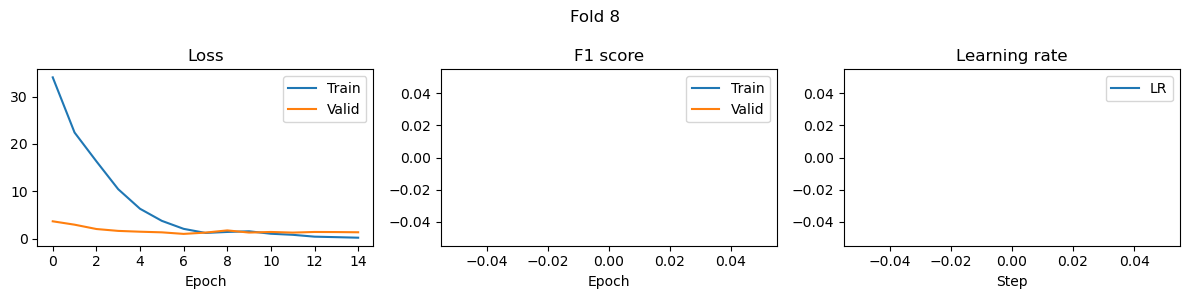

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
valid,4,4,3,3,3,4,3,4,3,9,...,3,10,7,3,3,5,3,4,6,3
train,42,30,28,31,30,30,29,33,34,78,...,28,90,59,29,29,41,33,30,55,28


Model parameters: 210_799_256
[Training] Epoch 0 : Loss: 0.16335 - Acc : 0.04026 - LogLoss 3.66977
[Evaluation] Loss: 0.11560 - Acc : 0.04167 - LogLoss 3.63746
New best score: 1000000.0000 -> 3.6375
[Training] Epoch 1 : Loss: 0.10688 - Acc : 0.18690 - LogLoss 3.28856
[Evaluation] Loss: 0.09680 - Acc : 0.33333 - LogLoss 2.84122
New best score: 3.6375 -> 2.8412
[Training] Epoch 2 : Loss: 0.07847 - Acc : 0.50000 - LogLoss 2.26290
[Evaluation] Loss: 0.07220 - Acc : 0.55208 - LogLoss 2.04571
New best score: 2.8412 -> 2.0457
[Training] Epoch 3 : Loss: 0.05105 - Acc : 0.72837 - LogLoss 1.38057
[Evaluation] Loss: 0.05683 - Acc : 0.65104 - LogLoss 1.57117
New best score: 2.0457 -> 1.5712
[Training] Epoch 4 : Loss: 0.03154 - Acc : 0.86538 - LogLoss 0.80153
[Evaluation] Loss: 0.04788 - Acc : 0.69792 - LogLoss 1.32660
New best score: 1.5712 -> 1.3266
[Training] Epoch 5 : Loss: 0.01697 - Acc : 0.96394 - LogLoss 0.40712
[Evaluation] Loss: 0.04781 - Acc : 0.68750 - LogLoss 1.29828
New best score: 1.3

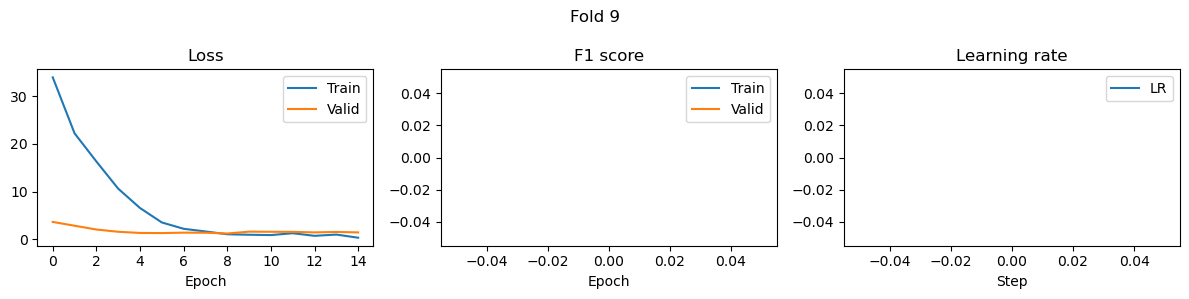

final logloss: 1.018726087794251


In [10]:
final_cv_loss = 0
for FOLD in range(CFG.folds):

    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train[train["folds"] != FOLD].reset_index(drop=True)
    fold_valid_data = train[train["folds"] == FOLD].reset_index(drop=True)

    display(
        pd.merge(
            fold_valid_data.groupby(by=["label"])["ID"].count().rename("valid").reset_index(),
            fold_train_data.groupby(by=["label"])["ID"].count().rename("train").reset_index(),
             on="label", how="left").T,)


    train_dataset = AudioDataset(fold_train_data, transforms=train_transforms)
    valid_dataset = AudioDataset(fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            # num_workers=4,
            # pin_memory=True,
            drop_last=True,
            # collate_fn=seg_dataset_collate
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        # num_workers=4,
        # pin_memory=True,
        drop_last=False,
        # collate_fn=seg_dataset_collate
    )



    model = timm.create_model(CFG.model_name, in_chans=1, pretrained=True, num_classes=40)
    
    model = model.to(CFG.device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=CFG.lr, 
                                  weight_decay=CFG.weight_decay
                                  )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader),
        )

    # TRAIN FOLD
    learning_rate_history = []
    train_loss_history = []
    train_score_history = []
    val_loss_history = []
    val_score_history = []

    criterion=torch.nn.BCELoss()

    best_loss = 1e6


    for epoch in range(0, CFG.epochs):
        # train_loss, train_lr = train_epoch(CFG, model, train_loader, optimizer, scheduler, epoch) # myown
        train_loss = training_fn(CFG, train_loader, model, optimizer, criterion,  epoch)
        
        train_loss_history.append(train_loss)
        # learning_rate_history.extend(train_lr)

        # val_loss = evaluate_model(CFG, model, valid_loader, epoch) # myown
        val_loss = evaluate(CFG, valid_loader, model, criterion)
        val_loss_history.append(val_loss)


        if (val_loss < best_loss):
            print(f"{STYLE.GREEN}New best score: {best_loss:.4f} -> {val_loss:.4f}{STYLE.END}")
            best_loss = val_loss
            torch.save(model.state_dict(), os.getcwd() + f'/models/best_model_fold_{FOLD}.pth')

    # plot train and validation loss, score and LR
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].plot(train_loss_history, label="Train")
    axes[0].plot(val_loss_history, label="Valid")
    axes[0].title.set_text("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(train_score_history, label="Train")
    axes[1].plot(val_score_history, label="Valid")
    axes[1].title.set_text("F1 score")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    axes[2].plot(learning_rate_history, label="LR")
    axes[2].legend()
    axes[2].title.set_text("Learning rate")
    axes[2].set_xlabel("Step")
    fig.suptitle(f"Fold {FOLD}")
    fig.tight_layout()
    plt.show()
    final_cv_loss += best_loss

print(f'final logloss: {final_cv_loss/CFG.folds}') 

In [ ]:
#1.3152694719940485 - MAXVITTINY-50EPOCHS
#1.2177959420477968  - maxvit-base 50 epochs
# 1.177012765417942 - maxvit-large

##### Submission

In [11]:
import gc
import ctypes

# free memory usage
def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [12]:
test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((224, 224)),
    v2.ToDtype(dtype=torch.float32, scale=False)

])


def inference(cfg, model, loader):
 
  predictions_labels = []
  predictions_proba = []

  out = None
  count = 0

  for data in tqdm(loader):
    x = data['image'].to(cfg.device)
  
    out = model(x)

    out = F.sigmoid(out) 
         
    out_labels = out.argmax(1).cpu().detach().numpy()
    out_probas = out.cpu().detach().numpy()

    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels, predictions_proba



test_dataset = AudioDataset(test, test_transforms, train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    # num_workers=1,
    # pin_memory=False,
    drop_last=False,
)

c:\Users\Propietario\miniconda3\envs\datascience\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
seed_everything(CFG.seed)

all_predictions = []

for FOLD in range(CFG.folds):
    print("Inference for fold:", FOLD)
    # model = AudioModel()
    model = timm.create_model(CFG.model_name, in_chans=1, num_classes=40, pretrained=True)
    model = model.to(CFG.device)
    model.load_state_dict(torch.load(os.getcwd() + f"/models/best_model_fold_{FOLD}.pth", map_location=CFG.device))
    model.eval()
    preds_label, preds_probs = inference(CFG, model, test_loader)
    all_predictions.append(preds_probs)



    # average predictions from fold models
    # test_data["probability"] += predictions.numpy() / len(CFG.train_folds)

Inference for fold: 0


C:\Users\Propietario\AppData\Local\Temp\ipykernel_31040\1105571510.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.getcwd() + f"/mod

Inference for fold: 1


100%|██████████| 911/911 [00:39<00:00, 23.07it/s]


Inference for fold: 2


100%|██████████| 911/911 [00:39<00:00, 23.29it/s]


Inference for fold: 3


100%|██████████| 911/911 [00:42<00:00, 21.45it/s]


Inference for fold: 4


100%|██████████| 911/911 [00:38<00:00, 23.46it/s]


Inference for fold: 5


100%|██████████| 911/911 [00:44<00:00, 20.68it/s]


Inference for fold: 6


100%|██████████| 911/911 [00:41<00:00, 21.81it/s]


Inference for fold: 7


100%|██████████| 911/911 [00:41<00:00, 21.78it/s]


Inference for fold: 8


100%|██████████| 911/911 [00:42<00:00, 21.62it/s]


Inference for fold: 9


100%|██████████| 911/911 [00:40<00:00, 22.52it/s]


In [14]:

preds_probs = np.mean(np.array(all_predictions), axis=0)

In [15]:
preds = pd.DataFrame(preds_probs, columns=list(class_map.keys()))
preds['ID'] = test['ID']
id_col = preds.pop(preds.columns[-1])
preds.insert(0, id_col.name, id_col) 
preds


,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0.002379,0.003389,0.004028,0.908579,0.001302,0.004068,0.002535,0.003169,0.000806,...,0.000562,0.002064,0.001299,0.006759,0.003615,0.001123,0.001180,0.001266,0.005124,0.000720
1,01S9OX,0.000637,0.000813,0.000464,0.002633,0.000963,0.000666,0.003478,0.001718,0.000913,...,0.003223,0.004805,0.002858,0.001275,0.003418,0.000550,0.000790,0.000728,0.002143,0.002632
2,02CS12,0.002194,0.001389,0.001760,0.001055,0.006680,0.001378,0.002117,0.005579,0.002732,...,0.006662,0.001535,0.004798,0.001151,0.001227,0.001983,0.002860,0.037236,0.001083,0.010211
3,02LM3W,0.005343,0.002105,0.003217,0.003115,0.002555,0.002733,0.022447,0.904838,0.003853,...,0.000831,0.002622,0.002012,0.002948,0.002346,0.000539,0.000452,0.002448,0.001653,0.000756
4,0C3A2V,0.001489,0.000670,0.000714,0.001247,0.000420,0.001254,0.001621,0.002039,0.000968,...,0.001661,0.004058,0.423379,0.002882,0.003138,0.002445,0.001736,0.001820,0.001515,0.001364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,ZOG4HO,0.003475,0.001612,0.001047,0.001664,0.000598,0.002100,0.000710,0.001347,0.001552,...,0.001203,0.003908,0.002446,0.003418,0.000559,0.001772,0.025027,0.001392,0.000471,0.057859
907,ZQ3ZNY,0.002640,0.002287,0.002965,0.002734,0.007438,0.003174,0.003438,0.001380,0.002338,...,0.002428,0.000973,0.000365,0.006311,0.004338,0.002994,0.003767,0.002299,0.000841,0.002827
908,ZV4TAN,0.936012,0.002211,0.000806,0.001851,0.002609,0.001282,0.003634,0.004729,0.000757,...,0.001165,0.000537,0.001261,0.000814,0.001265,0.001785,0.000872,0.001981,0.000567,0.001287
909,ZX1T49,0.000949,0.000681,0.002208,0.000474,0.002984,0.003409,0.011304,0.008014,0.003524,...,0.002883,0.001147,0.000574,0.000885,0.002439,0.001974,0.001694,0.001347,0.000564,0.001317


In [16]:
preds.describe()

,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,...,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,0.024437,0.018089,0.014447,0.015100,0.021453,0.018549,0.020639,0.019473,0.018559,0.042281,...,0.016804,0.049855,0.033101,0.010622,0.019777,0.023104,0.015940,0.019949,0.034586,0.014324
std,0.134058,0.113350,0.096269,0.097903,0.105708,0.115030,0.087845,0.099013,0.113239,0.156375,...,0.067345,0.186719,0.145802,0.074526,0.082548,0.117250,0.077327,0.093428,0.167960,0.085394
min,0.000153,0.000100,0.000340,0.000225,0.000115,0.000199,0.000278,0.000385,0.000356,0.000365,...,0.000389,0.000365,0.000258,0.000366,0.000314,0.000217,0.000204,0.000331,0.000301,0.000266
25%,0.000956,0.000818,0.001036,0.001020,0.000820,0.000931,0.001297,0.001316,0.001036,0.001709,...,0.001227,0.001348,0.001279,0.000852,0.001277,0.001099,0.001036,0.001056,0.001015,0.001227
50%,0.001622,0.001342,0.001536,0.001649,0.001705,0.001512,0.002319,0.002439,0.001775,0.002809,...,0.002364,0.002291,0.002127,0.001191,0.002098,0.001798,0.002127,0.001738,0.001651,0.002041
75%,0.002786,0.002238,0.002349,0.002939,0.003171,0.002429,0.006268,0.005062,0.002897,0.005857,...,0.004318,0.004179,0.003561,0.002089,0.004394,0.003011,0.004802,0.003796,0.002651,0.003937
max,0.942886,0.931569,0.872061,0.910995,0.894083,0.915560,0.799196,0.918681,0.919688,0.951444,...,0.713243,0.965443,0.935641,0.874130,0.821271,0.914197,0.854205,0.822821,0.967548,0.873178


In [17]:
preds.to_csv(f'subs/5_15secs_10folds_BCELoss-{CFG.model_name}__.csv', index=False)